# 短程-建立模型-平均價格_log

**線性模型**

In [26]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        # 使用正則表達式提取小時和分鐘
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# 對以下欄位進行 one-hot encoding（drop_first 用來避免共線性）
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵處理
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# ==========================================
# 選取建模時使用的特徵：
# 我們要使用與「出發時段」、「抵達時段」、「航空聯盟」、「機型分類」、「假期」、「Region」相關的 dummy 變數
# 以及數值特徵「飛行時間_分鐘」、「Cost of Living Index」、「GDP (PPP) per capita (in thousand USD)」
# ==========================================

# 找出所有欄位名稱中包含目標關鍵字的 dummy 變數
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '假期_', 'Region_']

dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]

# 最後的特徵欄位：dummy 變數 + 數值特徵
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 檢查選取的特徵
print("選取的特徵欄位:", feature_cols)

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 分割數據集（訓練集與測試集）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 建立線性回歸模型
model = LinearRegression()
model.fit(X_train, y_train)

# 模型預測
y_pred = model.predict(X_test)

# 模型評估
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("測試集 MSE:", mse)
print("測試集 R^2:", r2)

# 產出模型公式
intercept = model.intercept_
coefficients = model.coef_
features = X.columns

formula = "平均價格_log = {:.3f}".format(intercept)
for coef, feat in zip(coefficients, features):
    formula += " + ({:.3f} * {})".format(coef, feat)
print("模型公式:")
print(formula)

選取的特徵欄位: ['出發時段_下午班機', '出發時段_凌晨班機', '出發時段_早晨班機', '出發時段_晚間班機', '抵達時段_下午抵達', '抵達時段_凌晨抵達', '抵達時段_早晨抵達', '抵達時段_晚間抵達', '航空聯盟_1', '航空聯盟_2', '航空聯盟_3', '航空聯盟_4', '機型分類_0', '機型分類_1', '機型分類_2', '假期_1', 'Region_日本', 'Region_泰國', 'Region_韓國', 'Region_香港', '飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
測試集 MSE: 0.09691757620155543
測試集 R^2: 0.7197694090672743
模型公式:
平均價格_log = 729080894386.410 + (-0.103 * 出發時段_下午班機) + (-0.204 * 出發時段_凌晨班機) + (0.020 * 出發時段_早晨班機) + (-0.238 * 出發時段_晚間班機) + (0.019 * 抵達時段_下午抵達) + (0.075 * 抵達時段_凌晨抵達) + (-0.009 * 抵達時段_早晨抵達) + (0.095 * 抵達時段_晚間抵達) + (0.315 * 航空聯盟_1) + (0.290 * 航空聯盟_2) + (0.408 * 航空聯盟_3) + (-0.220 * 航空聯盟_4) + (-0.297 * 機型分類_0) + (-0.185 * 機型分類_1) + (-0.182 * 機型分類_2) + (0.339 * 假期_1) + (-292749286934.124 * Region_日本) + (-206770274216.923 * Region_泰國) + (-983544524018.057 * Region_韓國) + (-1385719171754.580 * Region_香港) + (-0.097 * 飛行時間_分鐘) + (945145845623.709 * Cost of Living Index) + (-734749430962.281 * GDP (PPP) per capita (in thou

In [14]:
import re
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 確保 y 為正數（Box-Cox 轉換要求 y > 0）
y_shifted = y + 1 - y.min()

# 進行 Box-Cox 轉換
y_boxcox, lambda_val = boxcox(y_shifted)

# 設定五組隨機種子
seeds = [123, 234, 345, 456, 567]
results = []

for seed in seeds:
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size=0.3, random_state=seed)

    # 建立線性回歸模型
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 預測
    y_pred = model.predict(X_test)

    # 轉換回原始尺度
    y_pred_original = (y_pred * lambda_val + 1) ** (1 / lambda_val) + y.min() - 1

    # 評估
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 儲存結果
    results.append({'Seed': seed, 'MSE': mse, 'R^2': r2})

# 轉換為 DataFrame 並顯示
results_df = pd.DataFrame(results)
print("Box-Cox 轉換後的線性模型結果:")
print(results_df)

# 顯示最佳 lambda 值
print(f"Box-Cox 最佳 lambda: {lambda_val:.4f}")

Box-Cox 轉換後的線性模型結果:
   Seed       MSE       R^2
0   123  0.081212  0.716505
1   234  0.082544  0.725743
2   345  0.082740  0.710654
3   456  0.084939  0.709586
4   567  0.088454  0.702831
Box-Cox 最佳 lambda: 0.9294


**隨機森林**

In [9]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 設定五組隨機種子
seeds = [123, 234, 345, 456, 567]
results = []

for seed in seeds:
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # 建立隨機森林回歸模型
    model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)

    # 預測
    y_pred = model.predict(X_test)

    # 評估
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 儲存結果
    results.append({'Seed': seed, 'MSE': mse, 'R^2': r2})

# 轉換為 DataFrame 並顯示
results_df = pd.DataFrame(results)
print(results_df)

   Seed       MSE       R^2
0   123  0.079790  0.753550
1   234  0.080011  0.764896
2   345  0.082701  0.744487
3   456  0.083431  0.747748
4   567  0.090387  0.732020


**SVR**

In [7]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化（SVM 需要標準化）
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 設定五組隨機種子
seeds = [123, 234, 345, 456, 567]
results = []

for seed in seeds:
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # 建立 SVR 模型
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # RBF 核函數
    model.fit(X_train, y_train)

    # 預測
    y_pred = model.predict(X_test)

    # 評估
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 儲存結果
    results.append({'Seed': seed, 'MSE': mse, 'R^2': r2})

# 轉換為 DataFrame 並顯示
results_df = pd.DataFrame(results)
print(results_df)

   Seed       MSE       R^2
0   123  0.076508  0.763688
1   234  0.078265  0.770026
2   345  0.078759  0.756665
3   456  0.077367  0.766080
4   567  0.086580  0.743309


**XGBoost**

   Seed       MSE       R^2
0   123  0.075720  0.766122
1   234  0.077469  0.772365
2   345  0.078924  0.756156
3   456  0.079113  0.760803
4   567  0.085581  0.746270


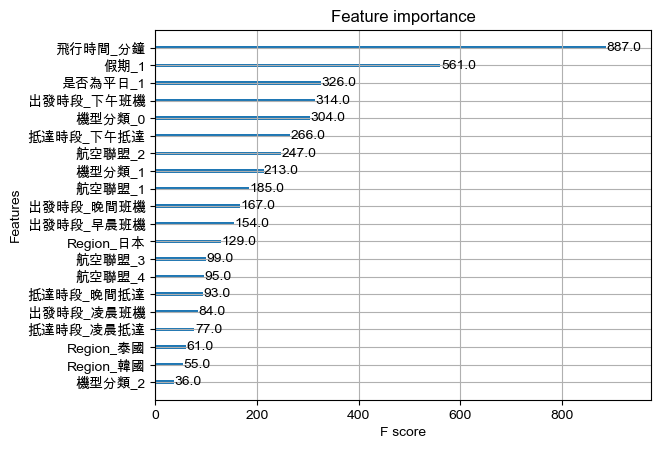

In [12]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化（XGBoost **不一定** 需要標準化，但可以做）
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 設定五組隨機種子
seeds = [123, 234, 345, 456, 567]
results = []

for seed in seeds:
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # 建立 XGBoost 模型
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)

    # 預測
    y_pred = model.predict(X_test)

    # 評估
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 儲存結果
    results.append({'Seed': seed, 'MSE': mse, 'R^2': r2})

# 轉換為 DataFrame 並顯示
results_df = pd.DataFrame(results)
print(results_df)

# 繪製特徵重要性圖
xgb.plot_importance(model, max_num_features=20)
plt.show()